<a href="https://colab.research.google.com/github/messerb5467/kaggle-competitions/blob/main/gendered-coref/GenderedPronounsDataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
In this notebook, I'm going to work throught the kaggle [gendered pronoun resolution competition](https://www.kaggle.com/c/gendered-pronoun-resolution/data). Motivations are that mostly for fun and learning, but fairness in AI is a very important topic, especially with the wake of numerous upsets I will leave to the reader to investigate more on their own.

# Stepping into the problem

Analyzing this from a very high level perspective, this is a very targeted problem that shouldn't require the use of multiple models arranged in a hierarchical or interlacing nature as I'm not trying to take the results of one model, say a voice synthesis focused model and translate that into something that a backend model, a natural language model, for further understanding of what's going on in my use case.

Before I make any more judgements though, I really do need to bring in the dataset for analysis to understand precisely what model needs used. My initial thought based on the provided examples from the course overview page are that a bidirectional lstm could be very useful towards addressing this particular use case.

# Bringing in the data
The data itself is available in a couple locations (the kaggle dashboard as well as a [linked github repo](https://github.com/google-research-datasets/gap-coreference)) and for ease of reproducibility, I'm going to focus on importing the data from the github repo using the below command.

In [2]:
!git clone https://github.com/google-research-datasets/gap-coreference

Cloning into 'gap-coreference'...
remote: Enumerating objects: 19, done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 19
Unpacking objects: 100% (19/19), done.


## Reviewing the data
An initial look at the README.md provided in the github repo presupposes this as tab-separated values instead of the normal comma-separated values dataset, but overall does not provide any damper at really looking into this overall problem. It should be incredibly easy to actually get this thing imported, reviewed and cleaned.

While I know that I eventually want to manipulate this in tensorflow, I just want to start by getting an idea of what this dataset looks like in pandas. If I were to scale this out or do this purely in tensorflow, I would rely on the Tensorflow datasets api to bring this in and clean and even Tensorflow Data validation to get a better look of what's going on inside of the data.

In [3]:
import pandas as pd

In [4]:
df_train = pd.read_csv('gap-coreference/gap-development.tsv', sep='\t')

In [6]:
df_train.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,True,Pauline,207,False,http://en.wikipedia.org/wiki/List_of_Teachers_...
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,True,Bernard Leach,251,False,http://en.wikipedia.org/wiki/Warren_MacKenzie
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,False,De la Sota,246,True,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,False,Henry Rosenthal,336,True,http://en.wikipedia.org/wiki/Crime_(band)
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,False,Rivera,294,True,http://en.wikipedia.org/wiki/Jessica_Rivera


Looking at the above data, I have some thoughts at really working through this data cleaning. Keep these thoughts in mind depending on how your data is made in production as you may have to recreate these exact steps when making the port over into your own data pipeline. Here's the steps in detail:

1. Dropping the URL field - Without any more specific business context, I don't have much I can really do with this. Thus, let's get it out of the way.
2. Understanding statistics of the different offset lengths into the text and tokenizing it - Sequence models like RNNs and LSTMs don't perform incredibly well when we need to perform long-range time dependencies. Normal is oftentimes described as 400-500+ and we can get through this issue by tokenizing the output to get rid of any filler words. You can also use an embedding for dimensionality reduction here (preferably pre-trained so we don't spend extra time wasting CPU cycles when bigger companies have already done this on massive datasets the likes of which you'll only see in something like an HPC or research environment), but I personally see this as more of a text-scanning problem than I do as something that would be solved by an embedding.

In [7]:
df_train = df_train.drop(columns=['URL'])

In [8]:
df_train[['Pronoun-offset', 'A-offset', 'B-offset']].describe()

,Pronoun-offset,A-offset,B-offset
count,2000.000000,2000.00000,2000.000000
mean,324.963500,239.77800,300.535500
std,98.788591,111.15768,113.226357
min,3.000000,0.00000,16.000000
25%,274.000000,179.75000,237.000000
50%,316.000000,239.00000,294.000000
75%,370.000000,301.25000,358.000000
max,1135.000000,971.00000,1098.000000


The above stats really push the limits on what we'd be able to address what an RNN or LSTM would be able to accomplish on their own. Let's review the structure of the data again as well as the overall relatedness of what we're trying to handle and we could still consider an embedding for our usecase even after dropping out unnecessary words.

After looking over the dataset more, I wanted to expand on my choices of why to treat this as a text scanning problem over a choice to treat this as a text embedding problem. As shown [here](https://machinelearningmastery.com/what-are-word-embeddings/), text embeddings will produce a vectorized distance in multidimensional space and give you an overall idea of how the data is clustered within that space reminiscent of PCA or K-Means clustering. It is good to note that embeddings themselves are incredibly great at performing dimensionality reduction and I would highly encorage their use in a different set of problem, but this I still think is overall more accurately addressed as a text scanning problem where the model can make use of the antecedents for accurate classification.

# Coming back to the modeling

As mentioned in the project overview, our model needs to decide which of three results our model needs to produce (A, B, or neither). Let's provide a cleaned up dataset so we have something to talk to.

In [9]:
df_train = df_train.drop(columns=['Pronoun-offset', 'A-offset', 'B-offset'])

In [10]:
df_train.head()

,ID,Text,Pronoun,A,A-coref,B,B-coref
0,development-1,Zoe Telford -- played the police officer girlf...,her,Cheryl Cassidy,True,Pauline,False
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,MacKenzie,True,Bernard Leach,False
2,development-3,"He had been reelected to Congress, but resigne...",his,Angeloz,False,De la Sota,True
3,development-4,The current members of Crime have also perform...,his,Hell,False,Henry Rosenthal,True
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,Kitty Oppenheimer,False,Rivera,True


Above really focuses in on what we're trying to achieve overall in our modelling efforts. Make sure that a model scans a reduced text column, gives us an idea of whether the provided pronoun refers to A, B, or neither as described in the kaggle competition overview page.

Given the number of specialist topics, I've been learning, I've not gotten much time into specifically modelling one given problem or another so this will be a healthy stretch for me as well.

In particular, an LSTM cell will take a number of inputs as determined by the batch size we want to work with:

![lstm-cell-state-description](https://drive.google.com/uc?export=view&id=1I2dgRZO_9DfiUpxG1io1fJ6-m_1mmpvj)

and each token we use after data cleaning will be considered an input into this model.

# Refining our idea of the model

We've now figured out how we want to roughly handle the data inputs to the model and thus need to figure out what to do with the other data points. Remember that our model needs to produce a designation of which whether the pronoun coreferences A, B, or neither, which could be a C. In my mind, I'm really only looking to produce one of three at a given time, which I would then need to match my answer against as seen below. The tricky point for me is my first thought would be a many to one encoder-decoder architecture where the produced answer is compared against the true answer as part of a [custom loss function](https://neptune.ai/blog/keras-loss-functions).

To clarify, let me show the exact set of data I'm referring to below.

In [12]:
df_train[['Pronoun', 'A', 'A-coref', 'B', 'B-coref']].head()

,Pronoun,A,A-coref,B,B-coref
0,her,Cheryl Cassidy,True,Pauline,False
1,His,MacKenzie,True,Bernard Leach,False
2,his,Angeloz,False,De la Sota,True
3,his,Hell,False,Henry Rosenthal,True
4,She,Kitty Oppenheimer,False,Rivera,True


Having broken down the data this far, we'd want to focus in on how the decoder architecture is going to produce token(s) and then address this problem as appropriate. Keep in mind the model will have access to the pronoun under consideration, so the pronoun field actualy becomes redundant in our entire consideration. Thus, we drop the pronoun field and even the coreferential fields and treat the loss function as a low regular expression. If the produced answer is in A, that wins. In B, that wins. Else, we have neither.

In [13]:
df_train[['A', 'B']].head()

,A,B
0,Cheryl Cassidy,Pauline
1,MacKenzie,Bernard Leach
2,Angeloz,De la Sota
3,Hell,Henry Rosenthal
4,Kitty Oppenheimer,Rivera


In [23]:
df_train['A_len'] = df_train['A'].str.split(' ').str.len()
df_train['B_len'] = df_train['B'].str.split(' ').str.len()

In [24]:
df_train[['A_len', 'B_len']].describe()

,A_len,B_len
count,2000.000000,2000.00000
mean,1.526500,1.51250
std,0.688138,0.66488
min,1.000000,1.00000
25%,1.000000,1.00000
50%,1.000000,1.00000
75%,2.000000,2.00000
max,7.000000,6.00000


Looking at the above, I'm going to take a look at how many different outliers there are in the data using a couple histogram plots. If there's a low level of overall samples going out into the high number of tokens, I can probably just drop the samples from the data and move on as it would save me a ton of time when it comes to training the model. Please do note that according to the GCP ML engineer cert, that ML is really meant to model even the strangest nuances in your data. My biggest thought is if that I can save myself a lot of trouble and processing power only having to consider 2 nodes on my decoder instead of 7 nodes. That'll be incredibly beneificial in the long run.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f23873dd510>,
      dtype=object)

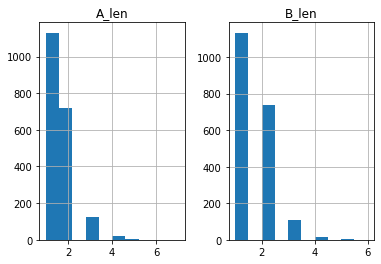

In [25]:
df_train[['A_len', 'B_len']].hist()

Very nicely, we have really small tails on both sides for the upper number of tokens. Let's repeat this for A_len and B_len for >= 3.

In [27]:
len_df = df_train[['A_len', 'B_len']].copy()

In [28]:
le

,A_len,B_len
0,2,1
1,1,2
2,1,3
3,1,2
4,2,1
...,...,...
1995,1,1
1996,2,1
1997,1,2
1998,1,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f238613a310>,
      dtype=object)

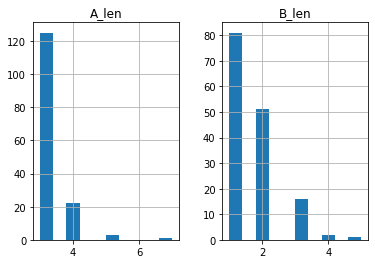

In [36]:
len_df[len_df['A_len'] >= 3].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2386019e10>,
      dtype=object)

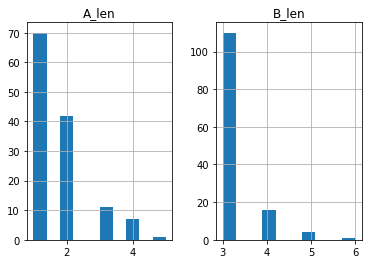

In [37]:
len_df[len_df['B_len'] >= 3].hist()

In this problem, I'd end up dropping out about 60 samples and would definitely want to get buyin from the business before just doing this. If you have someone that knows the nuances of the data in production, now would be a very great time to ask them for their opinion on how often coreferences with larger names appear in the actual output. Personally, though, I feel like this is a great tradeoff for the longer term though when we want to construct a continuous training and inference pipeline on something like kubeflow. No sense in making the business pay more than necessary for just the right amount of stuff that it needs.

For more detail, here's a rough drawing from an [article](https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639) by Akira Takezawa on towardsdatascience.com:
![seq2seq-model](https://drive.google.com/uc?export=view&id=1-09fxkhToEsiE9A2gYgSBQ4ZyqsPWHBy)

Finally another great picture of doing the seq2seq model with an embedding as shown here from [Guru99](https://www.guru99.com/seq2seq-model.html):
![seq2seq-embedding](https://drive.google.com/uc?export=view&id=1-5xW0pK3yKwR9xFNYv9xU_ttMWRSvK4p)

Overall, I think we've completed a good problem exploration and refinement session. We can decide in later sessions whether we want to use an embedding in our data cleaning, pre-trained or not. Really a fun few hours though.